In [98]:
import numpy as np
import matplotlib.pyplot as plt
import meshplot as mp
from sklearn.utils.random import sample_without_replacement
import itertools
from scipy.stats import multivariate_normal
from joblib import Parallel, delayed
import time
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from numpy.random import uniform

from utils import  sample_torus, sample_torus_angles
import gudhi as gd
from mapper import MapperComplex
from sklearn.cluster import KMeans
from scipy.spatial.distance import directed_hausdorff
from ot import gromov_wasserstein
from sklearn.manifold import MDS
from pyvis.network import Network
import matplotlib as mpl
import matplotlib.cm as cm
import networkx as nx


In [3]:
def max_dis(i,j,points,dd,D):
    I=list(dd.keys())[i]
    J=list(dd.keys())[j]
    if dd[I].size==0 or dd[J].size==0:
        return D
    return np.max((directed_hausdorff(points[dd[I],:],points[dd[J],:])[0],directed_hausdorff(points[dd[J],:],points[dd[I],:])[0]))

In [4]:
def get_ot_params(mapper,mes,points,D):

    dd={}
    st=mapper.simplex_tree
    for k in mapper.node_info.keys():
        dd[k]=mapper.node_info[k]['indices']

    for (splx,_) in st.get_skeleton(1):
        if len(splx) == 2:
            dd[str(splx)]=np.intersect1d(dd[splx[0]], dd[splx[1]],assume_unique=True)
            dd[splx[0]]=np.setdiff1d(dd[splx[0]], dd[str(splx)], assume_unique=True)
            dd[splx[1]]=np.setdiff1d(dd[splx[1]], dd[str(splx)], assume_unique=True)

    p=np.array([mes[dd[k]].sum() for k in dd.keys()])
    inds=np.triu_indices(len(dd.keys()))

    #dm=distance_matrix(vertices, vertices)

    out=Parallel(n_jobs=-1)(delayed(max_dis)(i, j,points,dd,D) for (i,j) in zip(*inds))

    C=np.zeros((len(dd.keys()),len(dd.keys())))

    l=list(zip(*inds))
    for k in range(len(l)):
        v=out[k]
        (i,j)=l[k]
        C[i,j]=v
        C[j,i]=v

    return(p,C)

In [5]:
R=0.75
r=0.25

In [6]:
points=sample_torus(200000,R,r)

In [7]:
points.shape

(200000, 3)

In [8]:
mp.plot(points);

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(2.2649765…

In [9]:
class custom_clustering:
    def __init__(self,R,r):
        self.R = R
        self.r = r

    def fit_predict(self,X):
        if np.sum(X[:,1]>(R-r)) + np.sum(X[:,1]<(-R+r)) >0:
            return np.repeat(0,X.shape[0])
        return (X[:,0]>0).astype(int)

In [10]:
clus=custom_clustering(R,r)

In [82]:
size=200000
resolutions=np.array([30])
gain=np.array([0.3])

f=points[:,1].reshape((-1,1))
c=np.repeat(1,points.shape[0]).reshape((-1,1))

In [83]:
mapper=MapperComplex(colors=c,filters=f,resolutions=resolutions, gains=gain, clustering=clus)
mapper.fit(points);

In [84]:
ni=mapper.node_info.copy()

In [85]:
edge_colors=[]


for (splx,_) in st.get_skeleton(1):
    if len(splx) == 2:
        inter=np.intersect1d(ni[splx[0]]['indices'], ni[splx[1]]['indices'],assume_unique=True)
        edge_colors.append(inter.size)
        ni[splx[0]]['indices']=np.setdiff1d(ni[splx[0]]['indices'], inter, assume_unique=True)
        ni[splx[1]]['indices']=np.setdiff1d(ni[splx[1]]['indices'], inter, assume_unique=True)

node_colors=[node['indices'].size for node in ni.values()]

edge_colors=np.array(edge_colors)/size
node_colors=np.array(node_colors)/size

In [87]:
np.sum(edge_colors)+np.sum(node_colors)

np.float64(1.0)

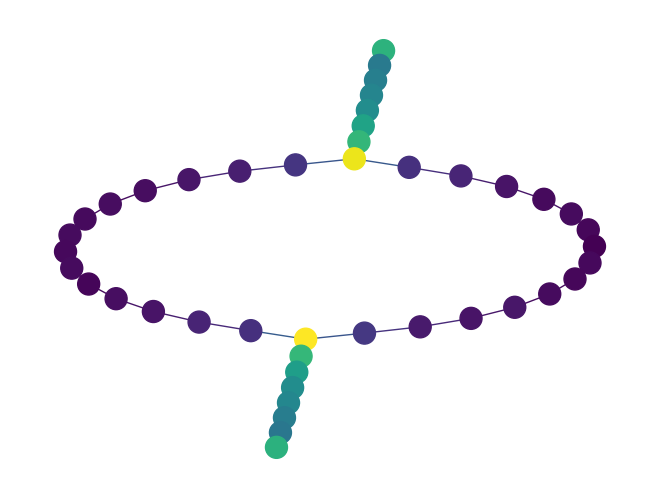

In [97]:
import networkx as nx
G = nx.Graph()
st=mapper.simplex_tree
for splx, _ in st.get_skeleton(1):
    if len(splx) == 1:
        G.add_node(splx[0])
    if len(splx) == 2:
        G.add_edge(splx[0], splx[1])


options = {
    "node_color": node_colors,
    "edge_color": edge_colors,
    "node_size":250,
    "width": 1,
    "with_labels": False,
}
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos,**options)
plt.show()

In [13]:
nt=mapper.get_pyvis()
nt.show('torus.html')

torus.html


In [146]:
p,C=get_ot_params(mapper,c/points.shape[0],points,R+r)

In [101]:
def sample_phi(size,alpha,beta):

    u=uniform(size=size)
    v=uniform(size=size)
    
    v[u<alpha]=v[u<alpha]*np.pi/3+5*np.pi/6
    v[(u>alpha)*(u<alpha+beta)]=v[(u>alpha)*(u<alpha+beta)]*np.pi/3-np.pi/6
    v[v<0]=v[v<0]+2*np.pi
    v[(u>alpha+beta)*(u<(1+alpha+beta)/2)]=v[(u>alpha+beta)*(u<(1+alpha+beta)/2)]*2*np.pi/3+np.pi/6
    v[u>(1+alpha+beta)/2]=v[u>(1+alpha+beta)/2]*2*np.pi/3+7*np.pi/6

    return v

In [102]:
def sample_torus_unbalanced(size,R,r,alpha,beta):
    n=int(size*2)
    
    
    
    #phi=uniform(size=size)*np.pi+(uniform(size=size)<1/4)*np.pi
    phi=sample_phi(size,alpha,beta)
    
    # Rejection sampling for theta
    theta=uniform(size=n)*2*np.pi
    
    u=uniform(size=n)
    
    theta=theta[u<=(R+r*np.cos(theta))/(R+r)]
    theta=theta[:size]

    x=(R+r*np.cos(theta))*np.cos(phi)
    y=(R+r*np.cos(theta))*np.sin(phi)
    z=r*np.sin(theta)
    
    return (np.array([x,y,z]).T)[:size,:]  

In [149]:
alpha=1/12
beta=1/12
points=sample_torus_unbalanced(200000,R,r,alpha,beta)
mp.plot(points);

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-8.344650…

In [158]:
np.random.seed(0)
size=int(5e5)
values=[1/12,1/6,1/3]
c=np.repeat(1,size).reshape((-1,1))
resolutions=np.array([30])
gain=np.array([0.3])
ps=[]
Cs=[]
for alpha,beta in tqdm(itertools.product(values,values)):
    points=sample_torus_unbalanced(size,R,r,alpha,beta)
    f=points[:,1].reshape((-1,1))
    mapper=MapperComplex(colors=c,filters=f,resolutions=resolutions, gains=gain, clustering=clus)
    mapper.fit(points);
    p_u,C_u=get_ot_params(mapper,c/size,points,R+r)
    ps.append(p_u)
    Cs.append(C_u)

9it [00:50,  5.61s/it]


In [159]:
points.shape

(500000, 3)

In [160]:
M=np.zeros((9,9))
for i in range(9):
    for j in range(i):
        T,l=gromov_wasserstein(Cs[i], Cs[j], p=ps[i], q=ps[j],symmetric=True,log=True)
        M[i,j]=l['gw_dist']
        M[j,i]=M[i,j]

In [161]:
embedding = MDS(n_components=2,dissimilarity='precomputed')
X = embedding.fit_transform(M)

In [162]:
list(itertools.product(values,values))

[(0.08333333333333333, 0.08333333333333333),
 (0.08333333333333333, 0.16666666666666666),
 (0.08333333333333333, 0.3333333333333333),
 (0.16666666666666666, 0.08333333333333333),
 (0.16666666666666666, 0.16666666666666666),
 (0.16666666666666666, 0.3333333333333333),
 (0.3333333333333333, 0.08333333333333333),
 (0.3333333333333333, 0.16666666666666666),
 (0.3333333333333333, 0.3333333333333333)]

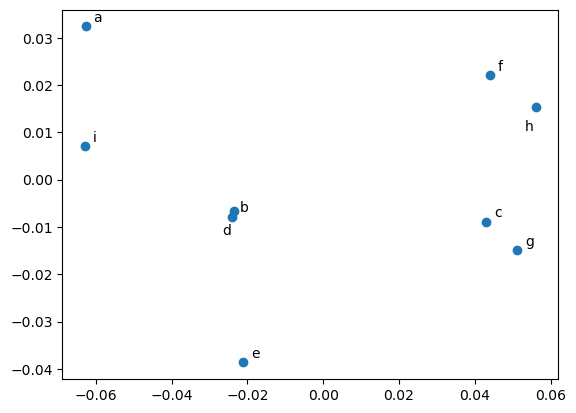

In [172]:

labels = ['a','b','c','d','e','f','g','h','i']

fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1])
for i, txt in enumerate(labels):
    if i==7 or i==3:
        ax.annotate(txt, (X[i,0], X[i,1]),(X[i,0]-0.003, X[i,1]-0.005))
    else:    
        ax.annotate(txt, (X[i,0], X[i,1]),(X[i,0]+0.002, X[i,1]+0.001))

fig.savefig("mds.png")

In [173]:
M.sum(axis=0)

array([0.69419561, 0.44729754, 0.49733636, 0.44467399, 0.54355171,
       0.51497607, 0.55239735, 0.57624176, 0.64675462])

## Graph visualization

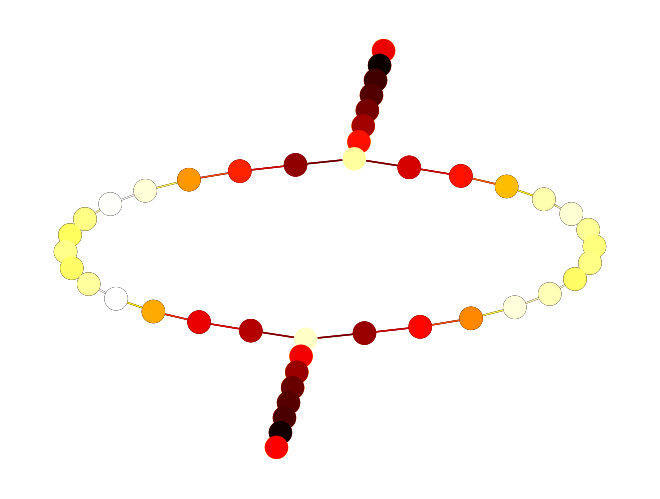

In [112]:
values=[1/12,1/6,1/3]
for alpha,beta in zip(values,values):
    points=sample_torus_unbalanced(size,R,r,alpha,beta)
    f=points[:,1].reshape((-1,1))
    mapper=MapperComplex(colors=c,filters=f,resolutions=resolutions, gains=gain, clustering=clus)
    mapper.fit(points);
    ni=mapper.node_info.copy()
    edge_colors=[]


    for (splx,_) in st.get_skeleton(1):
        if len(splx) == 2:
            inter=np.intersect1d(ni[splx[0]]['indices'], ni[splx[1]]['indices'],assume_unique=True)
            edge_colors.append(inter.size)
            ni[splx[0]]['indices']=np.setdiff1d(ni[splx[0]]['indices'], inter, assume_unique=True)
            ni[splx[1]]['indices']=np.setdiff1d(ni[splx[1]]['indices'], inter, assume_unique=True)
    
    node_colors=[node['indices'].size for node in ni.values()]
    
    edge_colors=np.array(edge_colors)/size
    node_colors=np.array(node_colors)/size
    G = nx.Graph()
    st=mapper.simplex_tree
    for splx, _ in st.get_skeleton(1):
        if len(splx) == 1:
            G.add_node(splx[0])
        if len(splx) == 2:
            G.add_edge(splx[0], splx[1])
    
    
    options = {
        "node_color": node_colors,
        "edge_color": edge_colors,
        "node_size":250,
        "edge_cmap": plt.cm.hot,
        "width": 1,
        "with_labels": False,
    }
    pos = nx.kamada_kawai_layout(G)
    nx.draw(G, pos,**options,cmap=plt.cm.hot)
    plt.savefig('mapper'+str(alpha)+'_'+str(beta)+'.png')